In [1]:
pip install tabpfn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('data/unique_outages.csv', parse_dates=['Start', 'Finish', 'file_name'])

# removed unplanned
df = df[df['Unplanned?'] != 1]
# filter the duration hours, only if there are expected outages, and non-outlier values, remove the one 'VIC/ TAS'
df = df[(df['Duration_Hours'] <= 1000) &(df['Duration_Hours'] != 0) & (df['Region'] != 'VIC/ TAS')]

df['Duration_Category'] = pd.qcut(df['Duration_Hours'], q=10, duplicates='drop')
df['Duration_Category'] = df['Duration_Category'].astype(str)

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score

# Define features and target
features = ['Recall_Day_Hours', 'Recall_Night_Hours',
            'Project Work?', 'DNSP Aware?', 'Generator Aware?', 'Inter-Regional',
            'Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description']
target = 'Duration_Category'

# Drop rows with missing values in relevant columns
df = df.dropna(subset=features + [target])

# Encode categorical features
X = df[features].copy()
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# Encode the target
y = LabelEncoder().fit_transform(df[target])

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


Classification Report (Test Set):

              precision    recall  f1-score   support

           0       0.57      0.65      0.61       119
           1       0.37      0.24      0.29        88
           2       0.54      0.67      0.60       215
           3       0.00      0.00      0.00        27
           4       0.48      0.30      0.37       101
           5       0.80      0.71      0.75       111
           6       0.59      0.59      0.59       114
           7       0.62      0.44      0.51       149
           8       0.49      0.66      0.56       226

    accuracy                           0.55      1150
   macro avg       0.50      0.47      0.48      1150
weighted avg       0.54      0.55      0.54      1150



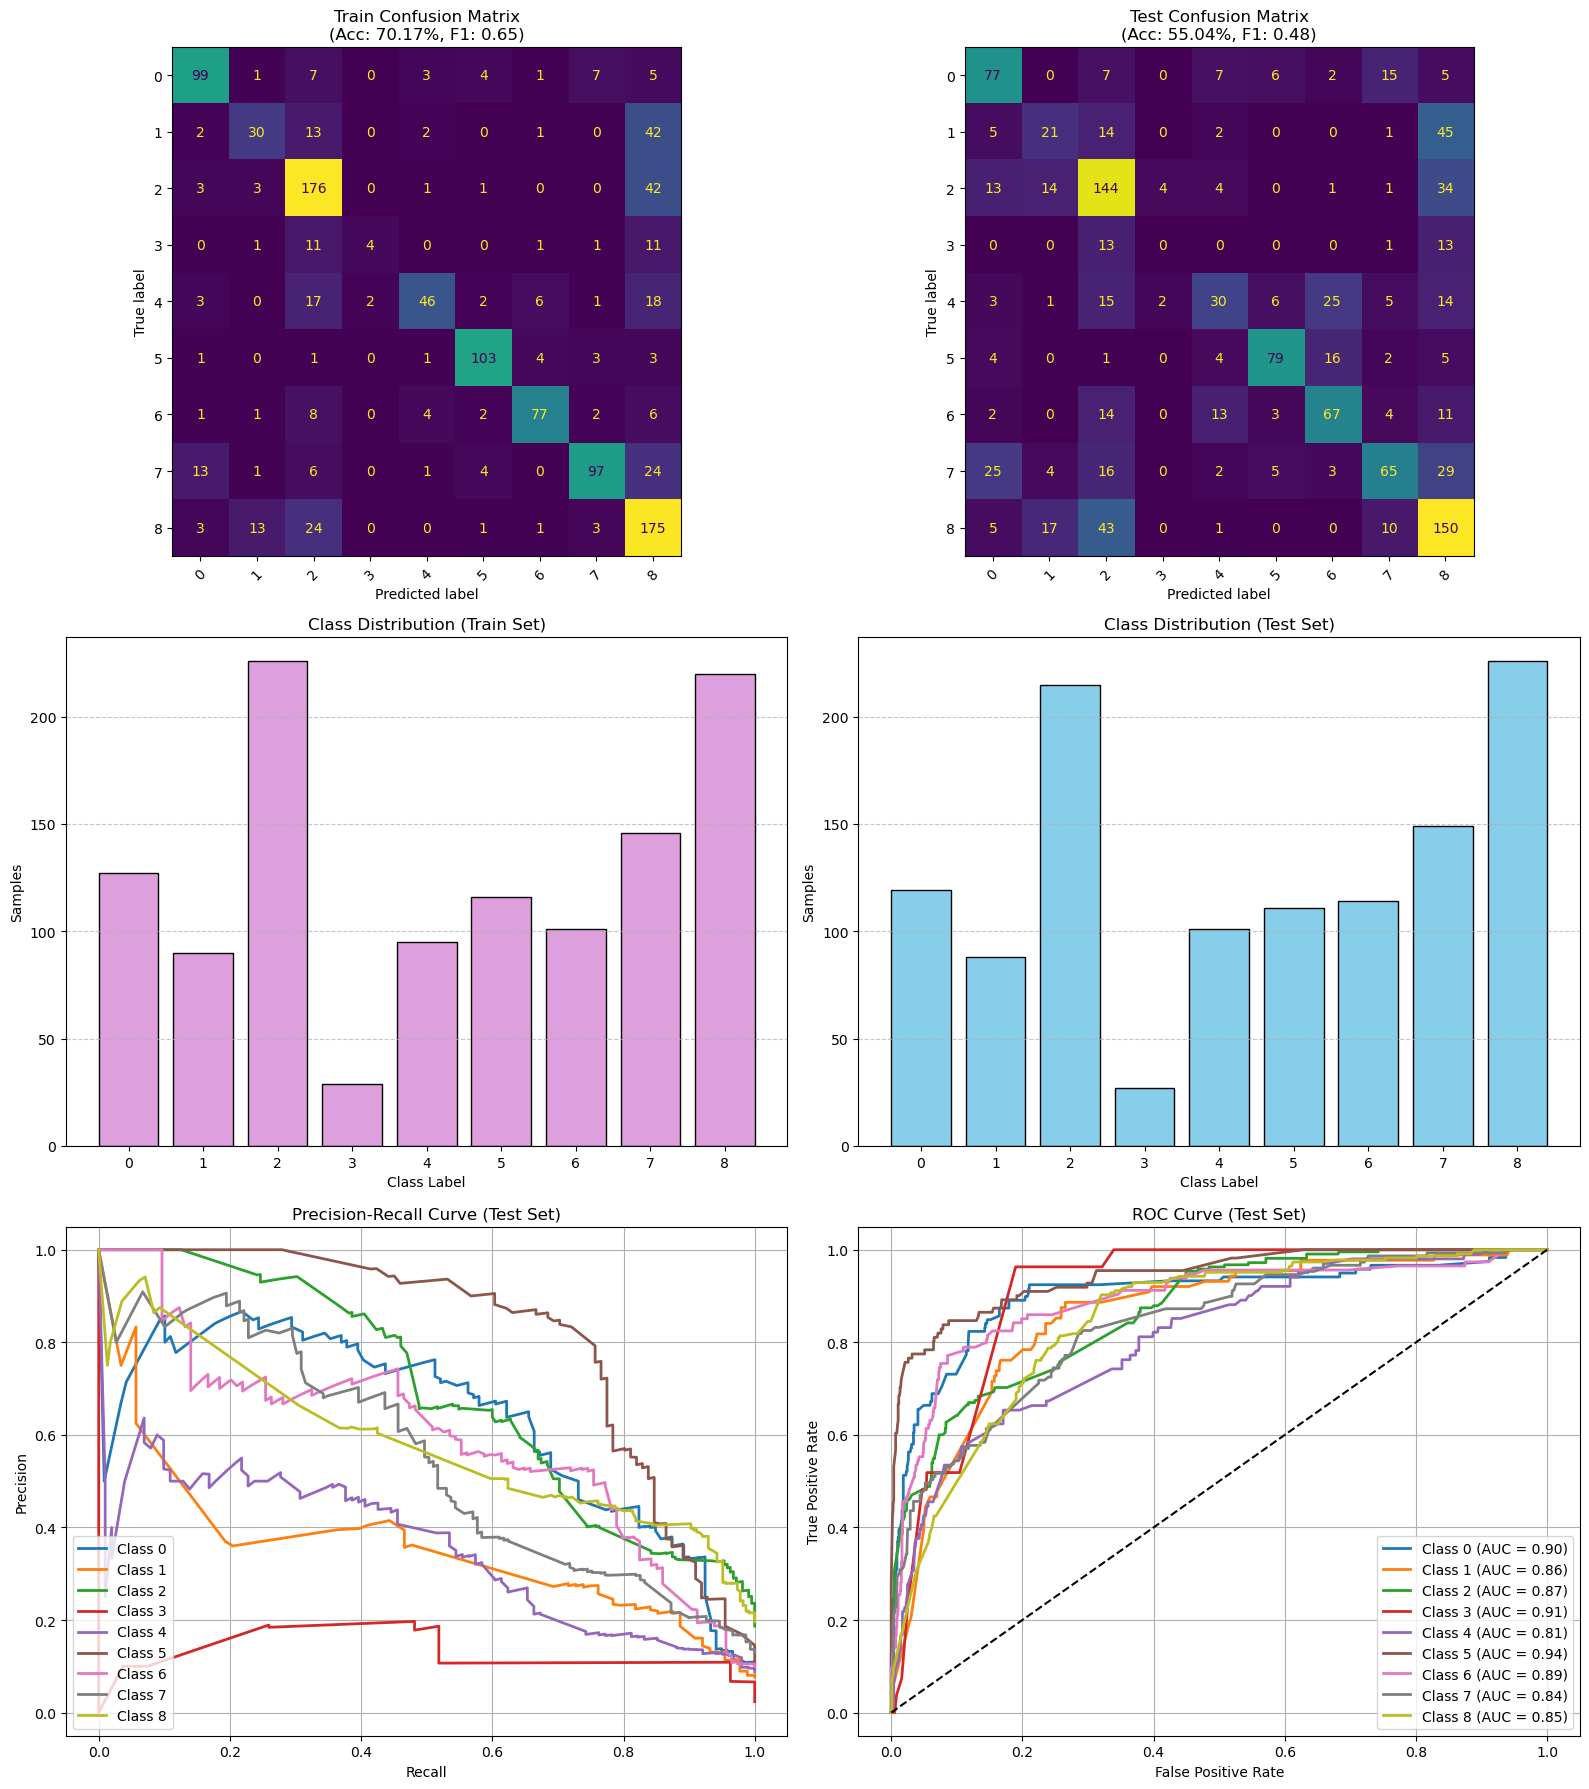

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tabpfn import TabPFNClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    precision_recall_curve, roc_curve, auc, accuracy_score, f1_score
)
from sklearn.preprocessing import label_binarize

# --- Train the classifier ---
clf = TabPFNClassifier(device="cuda")  # or "cpu" if needed
clf.fit(X_train, y_train)

# --- Predictions and probabilities ---
train_preds = clf.predict(X_train)
train_acc = accuracy_score(y_train, train_preds)
train_f1 = f1_score(y_train, train_preds, average="macro")

test_preds = clf.predict(X_test)
test_acc = accuracy_score(y_test, test_preds)
test_f1 = f1_score(y_test, test_preds, average="macro")

y_score = clf.predict_proba(X_test)

# --- Print classification report ---
print("\nClassification Report (Test Set):\n")
print(classification_report(y_test, test_preds))

# --- Prepare binarized labels for PR and ROC ---
y_test_bin = label_binarize(y_test, classes=clf.classes_)
n_classes = y_test_bin.shape[1]

# --- Set up 3x2 grid ---
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# --- Row 1: Confusion Matrices ---
# Train
train_cm = confusion_matrix(y_train, train_preds)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm)
disp_train.plot(cmap='viridis', ax=axes[0, 0], xticks_rotation=45, colorbar=False)
axes[0, 0].set_title(f"Train Confusion Matrix\n(Acc: {train_acc:.2%}, F1: {train_f1:.2f})")

# Test
test_cm = confusion_matrix(y_test, test_preds)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm)
disp_test.plot(cmap='viridis', ax=axes[0, 1], xticks_rotation=45, colorbar=False)
axes[0, 1].set_title(f"Test Confusion Matrix\n(Acc: {test_acc:.2%}, F1: {test_f1:.2f})")

# --- Row 2: Class Distributions ---
# Train
train_counts = pd.Series(y_train).value_counts().sort_index()
axes[1, 0].bar(train_counts.index.astype(str), train_counts.values, color='plum', edgecolor='black')
axes[1, 0].set_xlabel('Class Label')
axes[1, 0].set_ylabel('Samples')
axes[1, 0].set_title('Class Distribution (Train Set)')
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Test
test_counts = pd.Series(y_test).value_counts().sort_index()
axes[1, 1].bar(test_counts.index.astype(str), test_counts.values, color='skyblue', edgecolor='black')
axes[1, 1].set_xlabel('Class Label')
axes[1, 1].set_ylabel('Samples')
axes[1, 1].set_title('Class Distribution (Test Set)')
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

# --- Row 3: PR and ROC Curves ---
# Precision-Recall
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    axes[2, 0].plot(recall, precision, lw=2, label=f'Class {clf.classes_[i]}')
axes[2, 0].set_xlabel('Recall')
axes[2, 0].set_ylabel('Precision')
axes[2, 0].set_title('Precision-Recall Curve (Test Set)')
axes[2, 0].legend(loc='lower left')
axes[2, 0].grid()

# ROC Curve
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    axes[2, 1].plot(fpr, tpr, lw=2, label=f'Class {clf.classes_[i]} (AUC = {roc_auc:.2f})')
axes[2, 1].plot([0, 1], [0, 1], 'k--', lw=1.5)
axes[2, 1].set_xlabel('False Positive Rate')
axes[2, 1].set_ylabel('True Positive Rate')
axes[2, 1].set_title('ROC Curve (Test Set)')
axes[2, 1].legend(loc='lower right')
axes[2, 1].grid()

# --- Final layout ---
plt.tight_layout()
plt.show()

In [6]:
from tabpfn import TabPFNClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    precision_recall_curve, roc_curve, auc, accuracy_score, f1_score
)
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def train_and_evaluate_tabpfn(region_df, feature_cols, target_col):
    """
    Train TabPFNClassifier and plot evaluation metrics for a given region DataFrame.

    Parameters:
        region_df (pd.DataFrame): Region-specific data.
        feature_cols (list): List of feature column names.
        target_col (str): Name of the target column.

    Returns:
        clf (TabPFNClassifier): Trained model.
    """
    # Drop missing values
    region_df = region_df.dropna(subset=feature_cols + [target_col])

    # Encode features
    X = region_df[feature_cols].copy()
    for col in X.select_dtypes(include='object').columns:
        X[col] = LabelEncoder().fit_transform(X[col])

    # Encode target
    y = LabelEncoder().fit_transform(region_df[target_col])

    # Remove rare classes (fewer than 2 samples)
    class_counts = pd.Series(y).value_counts()
    valid_classes = class_counts[class_counts >= 2].index
    mask = np.isin(y, valid_classes)
    X = X[mask]
    y = y[mask]

    # Split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    # Train
    clf = TabPFNClassifier(device='cuda')
    clf.fit(X_train, y_train)

    # Predict
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)

    # Compute metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average="macro")
    test_f1 = f1_score(y_test, y_test_pred, average="macro")

    # Print classification report
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))

    # --- Create 3x2 subplot layout ---
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))

    # Row 1: Confusion matrices
    cm_train = confusion_matrix(y_train, y_train_pred)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
    disp_train.plot(cmap='viridis', ax=axes[0, 0], xticks_rotation=45, colorbar=False)
    axes[0, 0].set_title(f"Train Confusion Matrix\n(Acc: {train_acc:.2%}, F1: {train_f1:.2f})")

    cm_test = confusion_matrix(y_test, y_test_pred)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp_test.plot(cmap='viridis', ax=axes[0, 1], xticks_rotation=45, colorbar=False)
    axes[0, 1].set_title(f"Test Confusion Matrix\n(Acc: {test_acc:.2%}, F1: {test_f1:.2f})")

    # Row 2: Class distributions
    pd.Series(y_train).value_counts().sort_index().plot(
        kind='bar', ax=axes[1, 0], color='plum', edgecolor='black'
    )
    axes[1, 0].set_title("Train Class Distribution")
    axes[1, 0].set_xlabel("Class")
    axes[1, 0].set_ylabel("Count")
    axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

    pd.Series(y_test).value_counts().sort_index().plot(
        kind='bar', ax=axes[1, 1], color='skyblue', edgecolor='black'
    )
    axes[1, 1].set_title("Test Class Distribution")
    axes[1, 1].set_xlabel("Class")
    axes[1, 1].set_ylabel("Count")
    axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

    # Row 3: PR and ROC curves
    y_test_bin = label_binarize(y_test, classes=clf.classes_)
    n_classes = y_test_bin.shape[1]

    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        axes[2, 0].plot(recall, precision, lw=2, label=f'Class {clf.classes_[i]}')
    axes[2, 0].set_title("Precision-Recall Curve (Test Set)")
    axes[2, 0].set_xlabel("Recall")
    axes[2, 0].set_ylabel("Precision")
    axes[2, 0].legend(loc='lower left')
    axes[2, 0].grid()

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        axes[2, 1].plot(fpr, tpr, lw=2, label=f'Class {clf.classes_[i]} (AUC = {roc_auc:.2f})')
    axes[2, 1].plot([0, 1], [0, 1], 'k--', lw=1.5)
    axes[2, 1].set_title("ROC Curve (Test Set)")
    axes[2, 1].set_xlabel("False Positive Rate")
    axes[2, 1].set_ylabel("True Positive Rate")
    axes[2, 1].legend(loc='lower right')
    axes[2, 1].grid()

    # Final layout
    plt.tight_layout()
    plt.show()

    return clf



--- Region: SA ---

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.36      0.62      0.46        13
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         5
           3       0.36      0.33      0.34        15
           4       0.73      0.97      0.83        36
           5       1.00      0.10      0.18        10
           6       0.00      0.00      0.00         4

    accuracy                           0.58        85
   macro avg       0.35      0.29      0.26        85
weighted avg       0.55      0.58      0.51        85



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


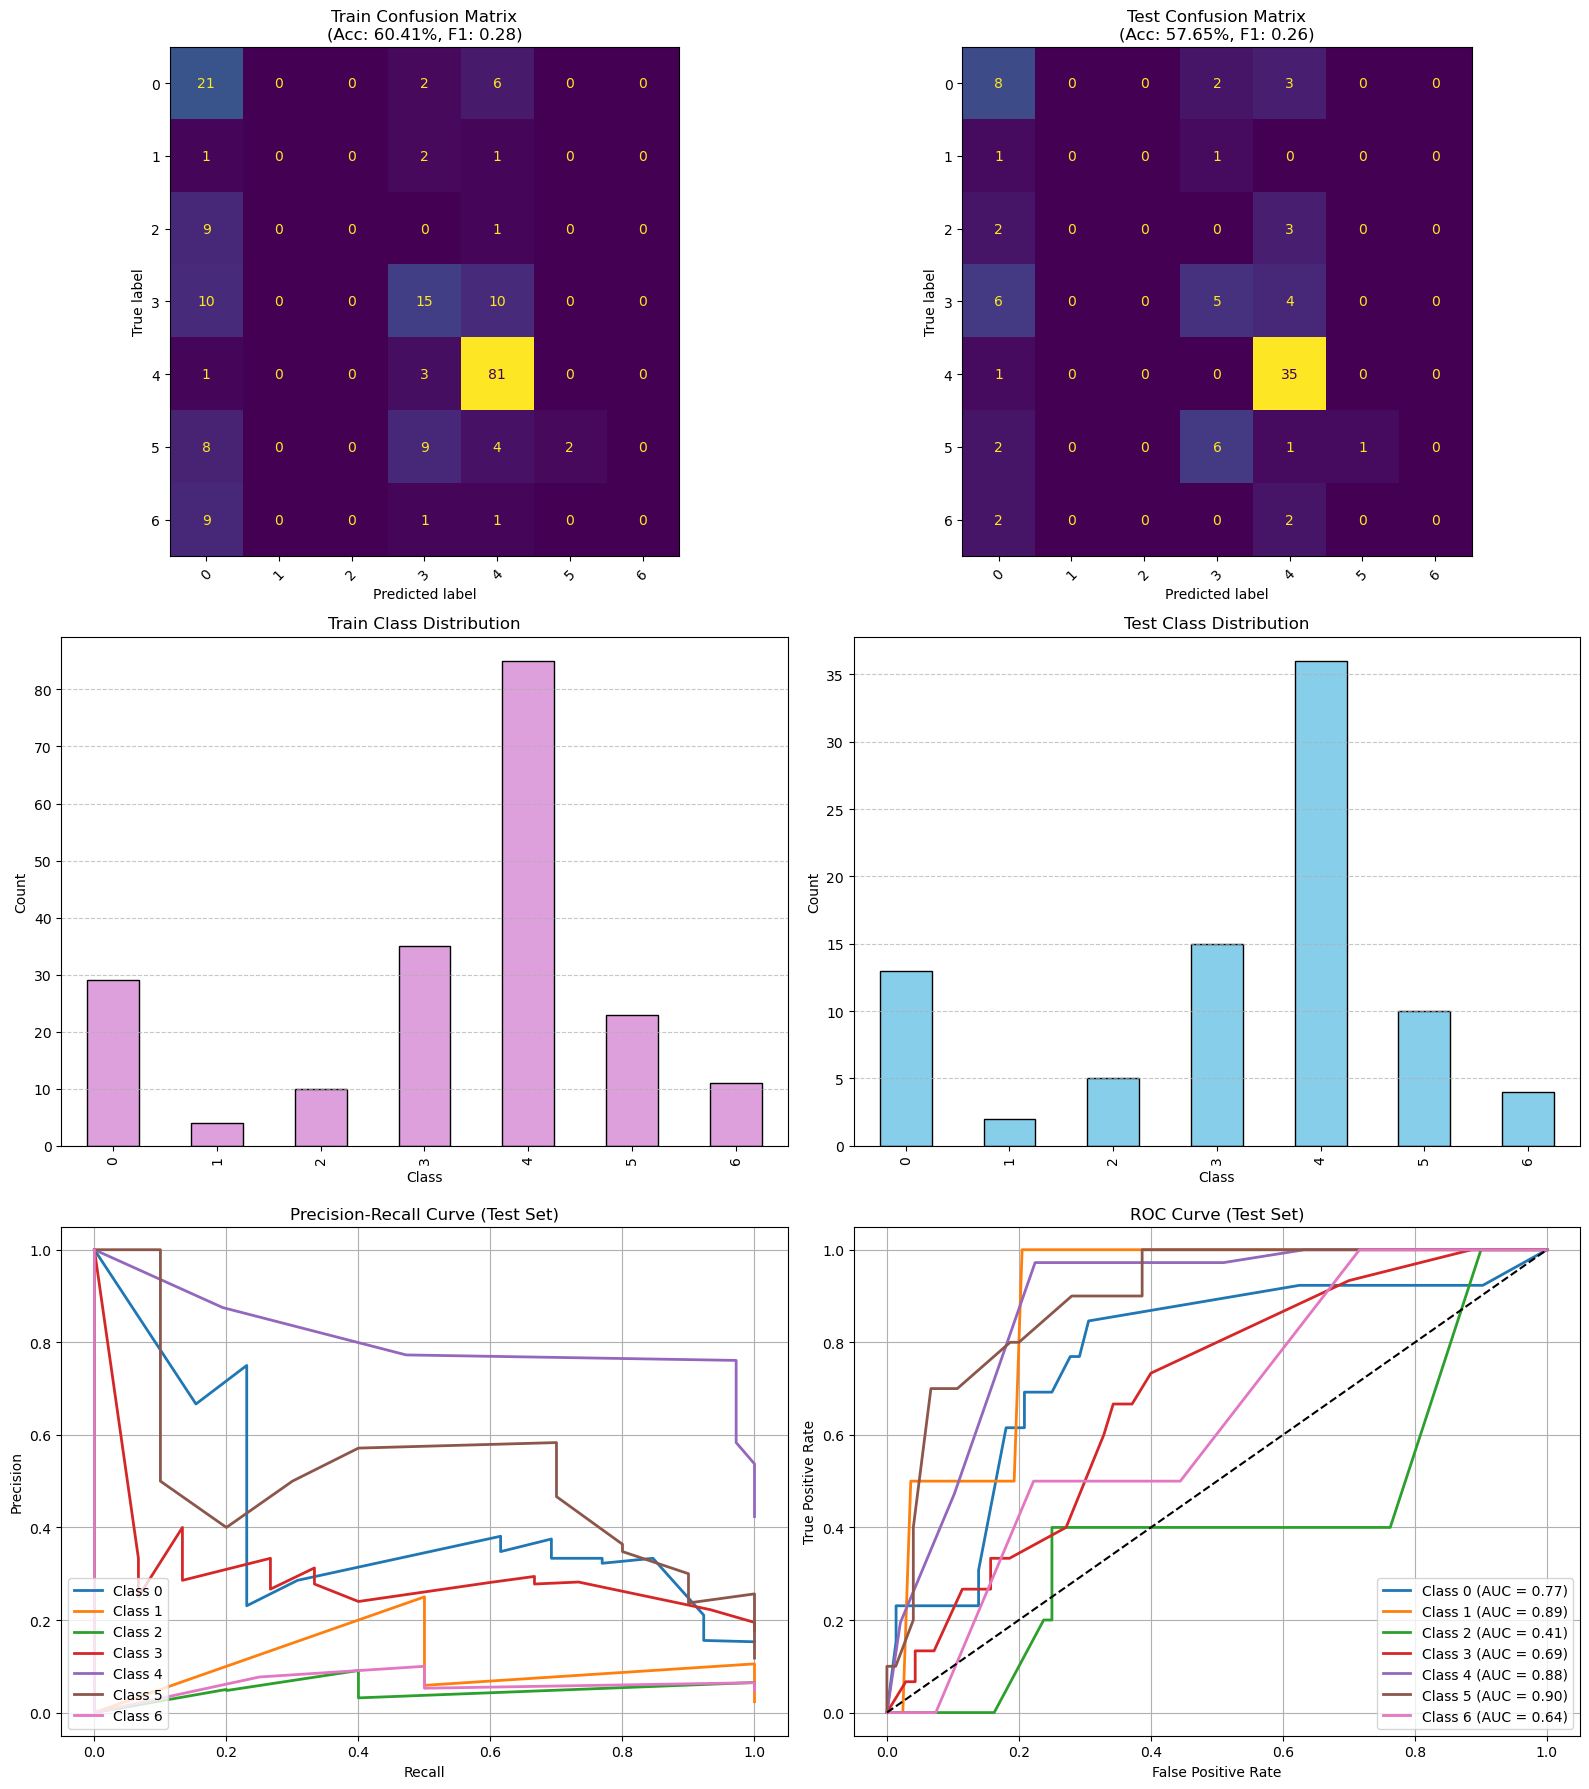


--- Region: VIC ---

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.75      0.29      0.41        21
           1       0.27      0.27      0.27        45
           2       0.55      0.43      0.49       113
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        23
           5       0.67      0.40      0.50         5
           6       0.29      0.10      0.15        20
           7       0.00      0.00      0.00        24
           8       0.39      0.80      0.52       106

    accuracy                           0.42       371
   macro avg       0.32      0.25      0.26       371
weighted avg       0.38      0.42      0.37       371



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


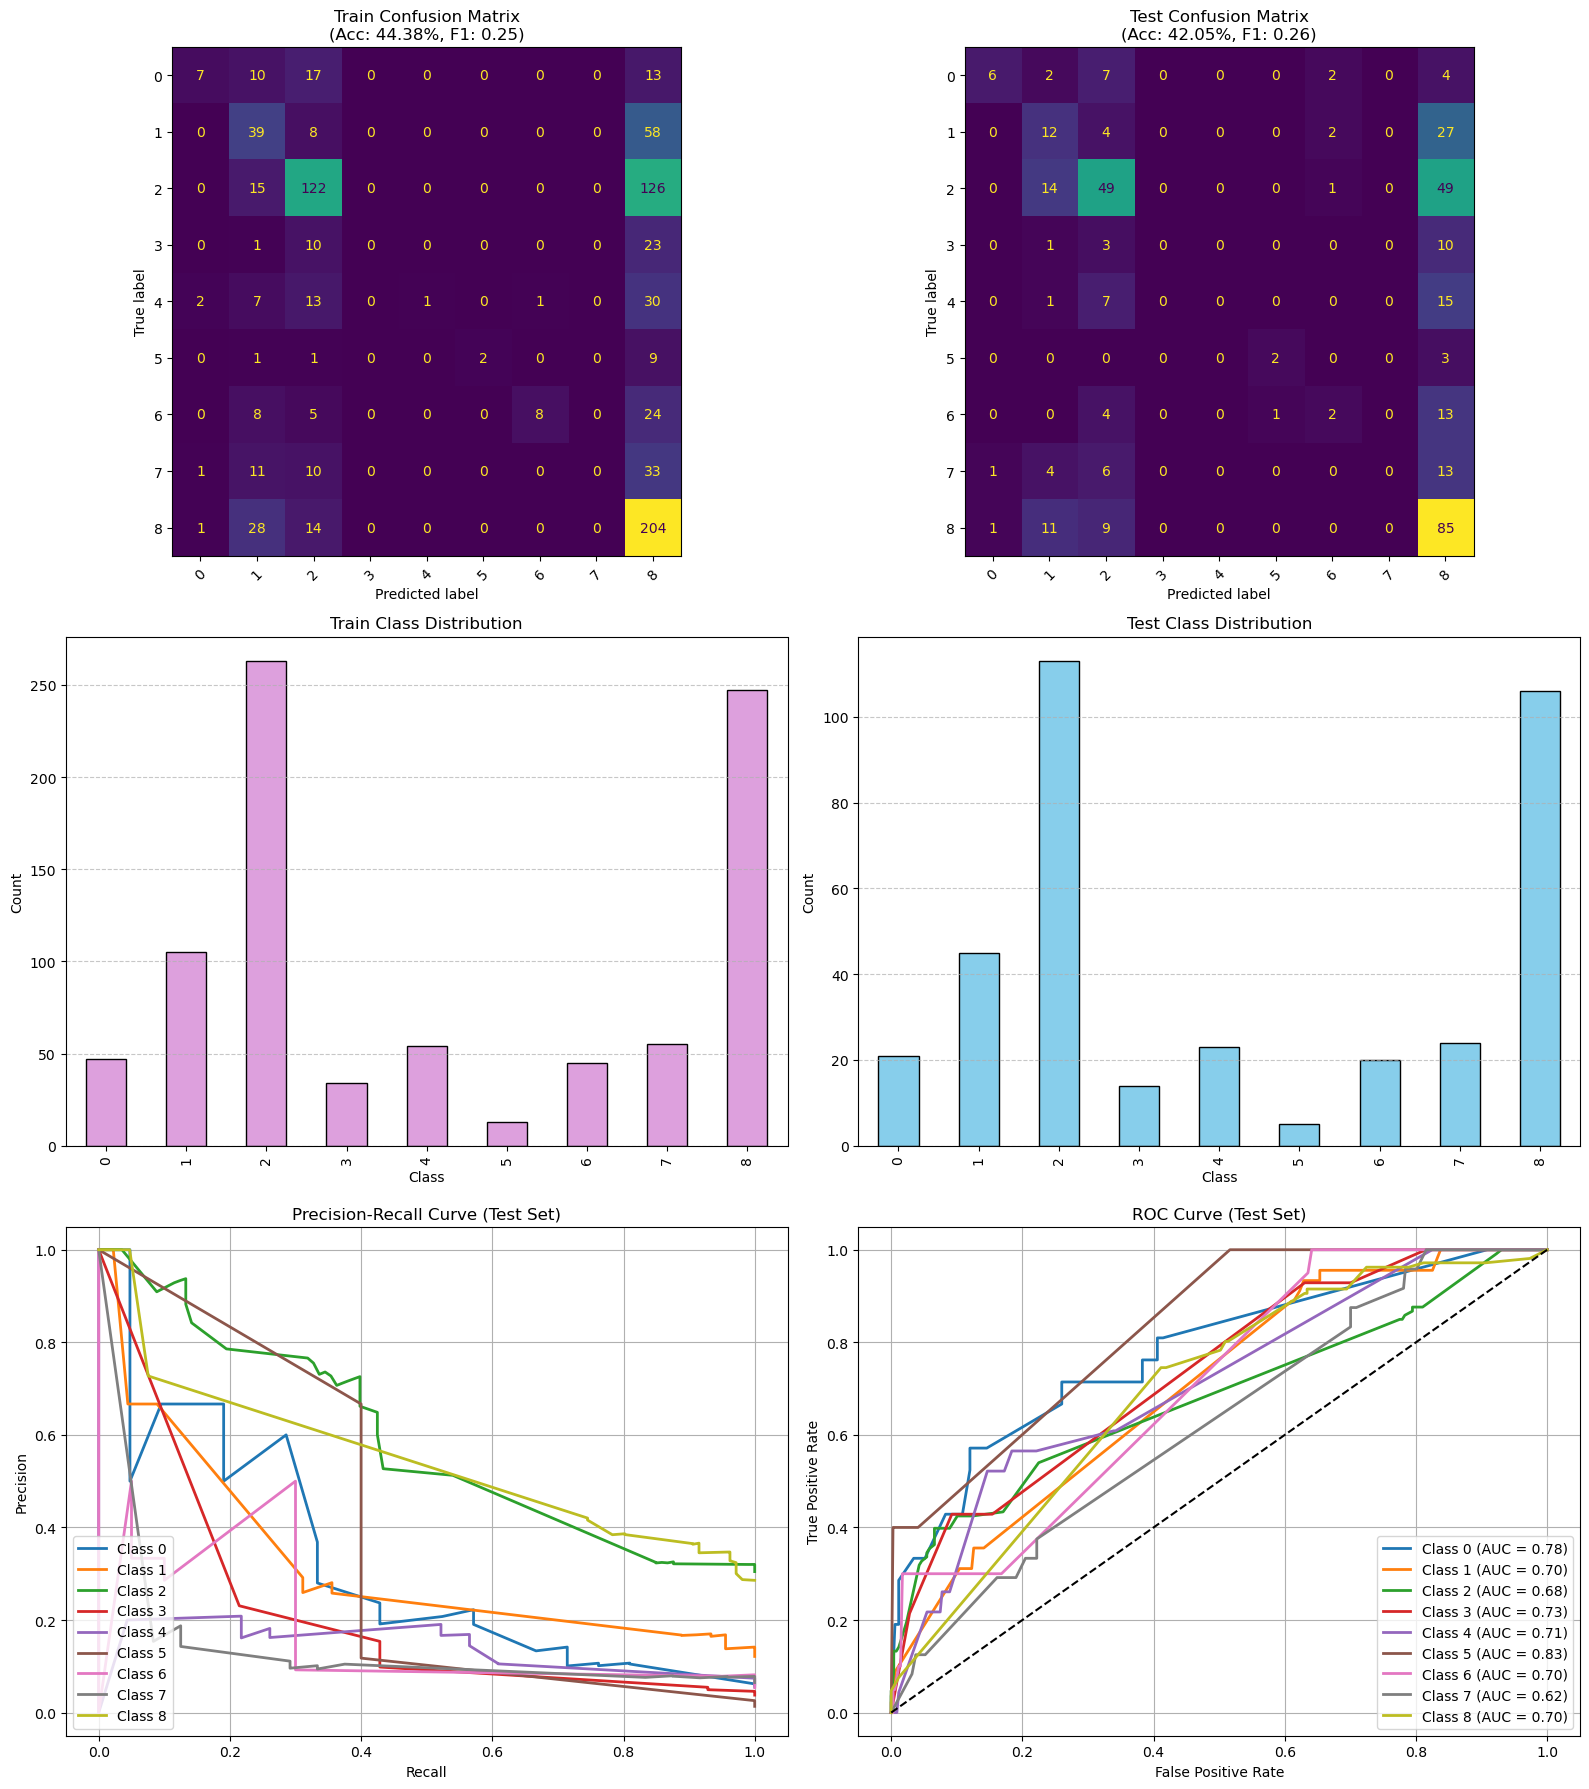


--- Region: TAS ---

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.53      0.53      0.53        15
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         6
           5       0.44      0.75      0.56        16
           6       0.00      0.00      0.00         1

    accuracy                           0.48        42
   macro avg       0.16      0.21      0.18        42
weighted avg       0.36      0.48      0.40        42



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


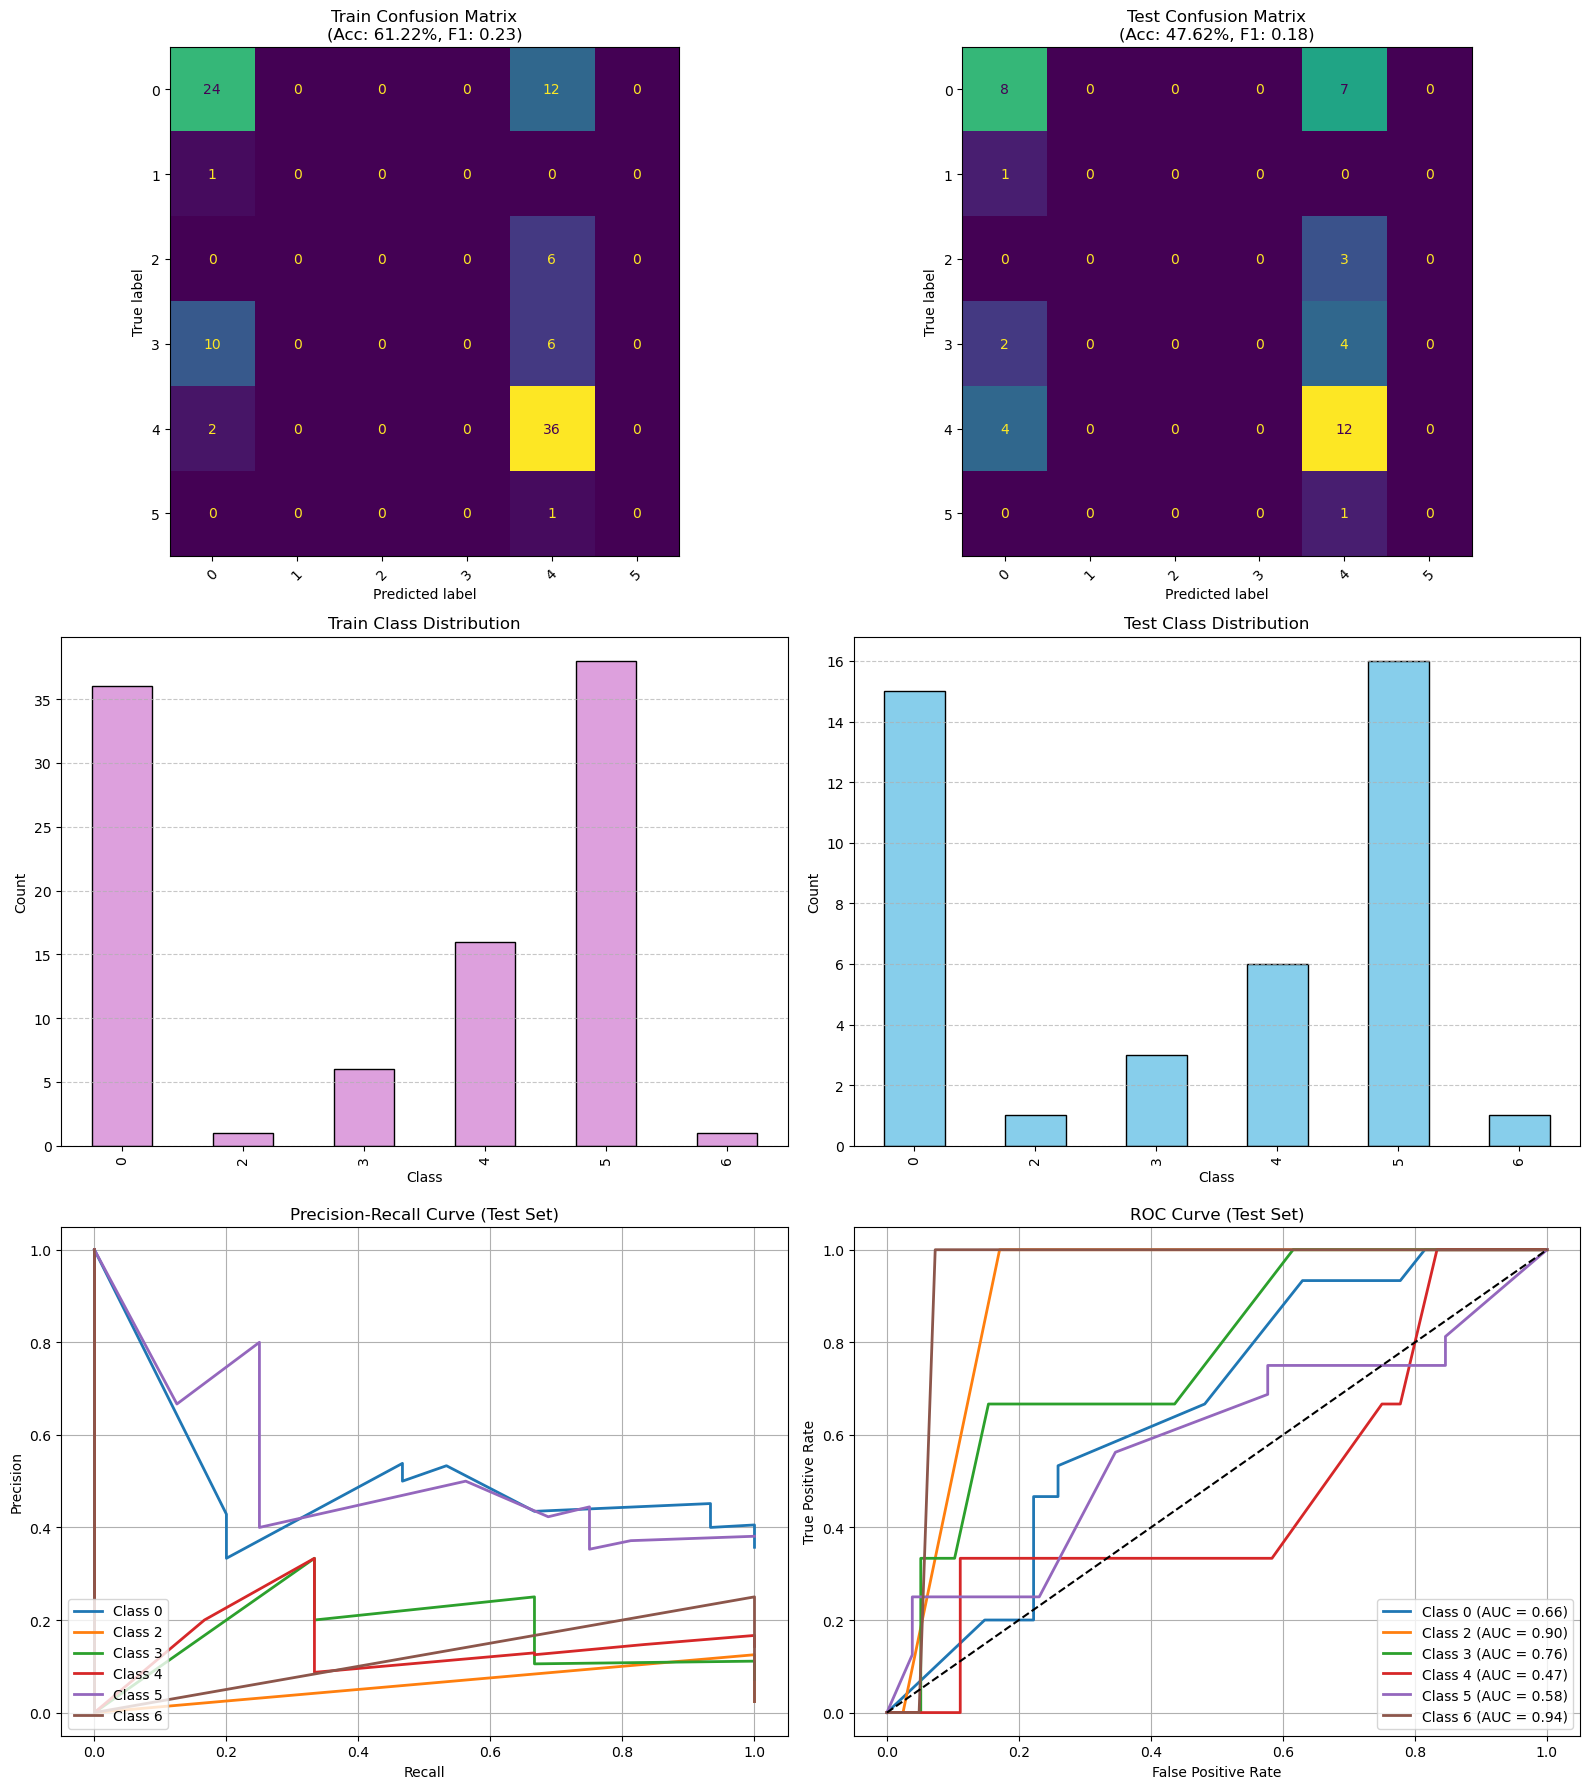


--- Region: QLD ---

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.53      0.43      0.47        21
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         9
           5       0.40      0.80      0.53        20
           6       0.40      0.14      0.21        14
           7       0.53      0.67      0.59        39
           8       0.00      0.00      0.00         7

    accuracy                           0.48       111
   macro avg       0.27      0.29      0.26       111
weighted avg       0.41      0.48      0.42       111



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


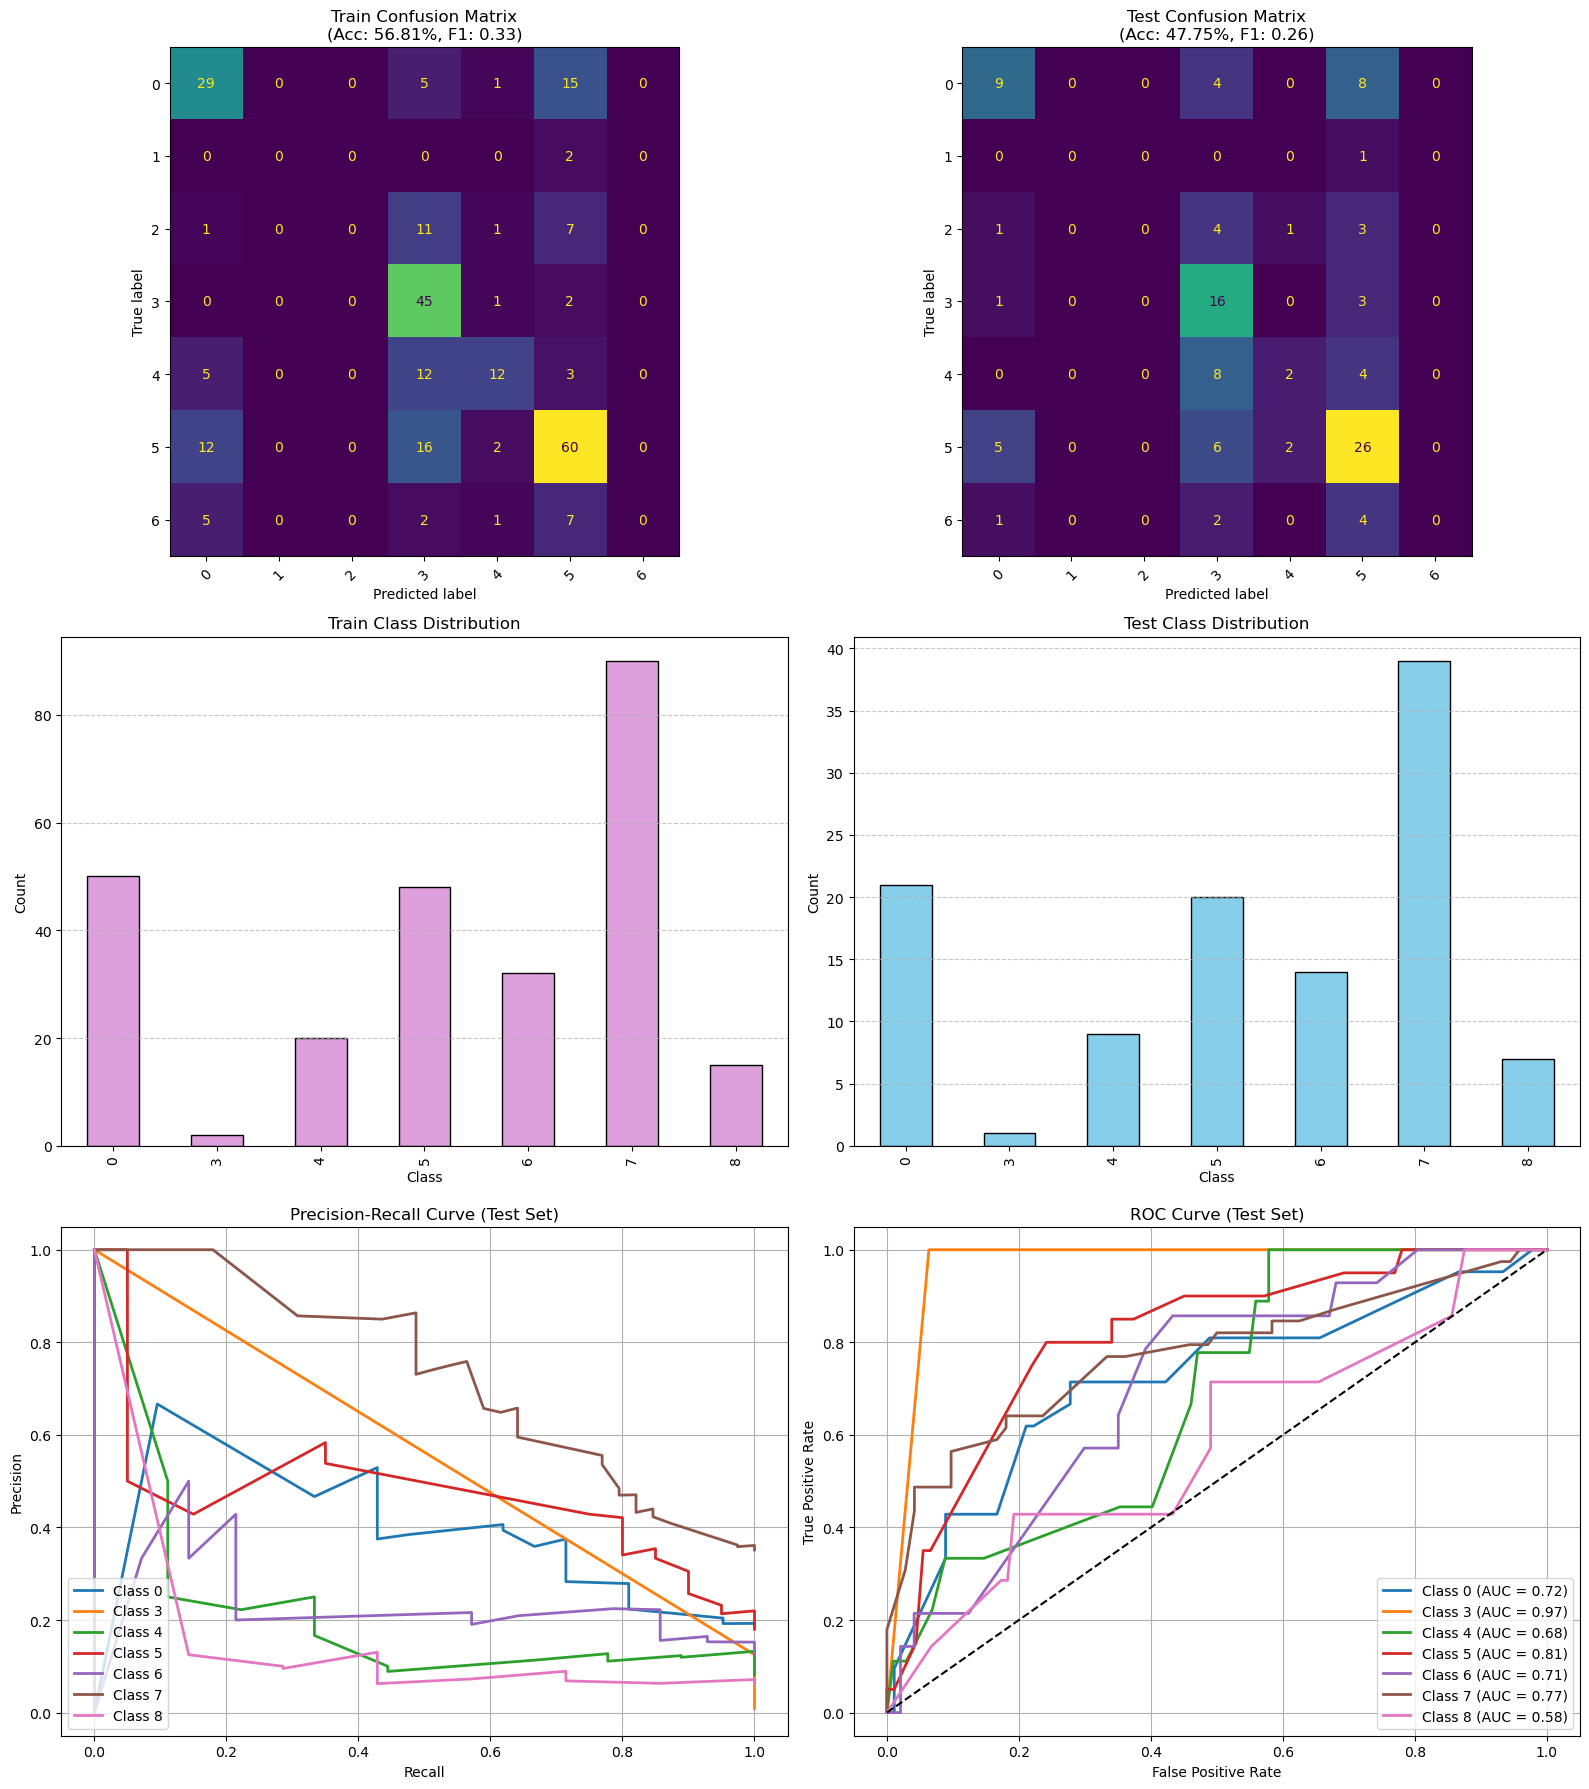


--- Region: NSW ---

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         6
           2       0.50      0.40      0.44        15
           3       0.00      0.00      0.00         2
           4       0.43      0.27      0.33        11
           5       0.00      0.00      0.00         3
           6       0.30      0.60      0.40        15
           7       0.00      0.00      0.00         5
           8       0.38      0.57      0.45        21

    accuracy                           0.37        82
   macro avg       0.18      0.20      0.18        82
weighted avg       0.30      0.37      0.32        82



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


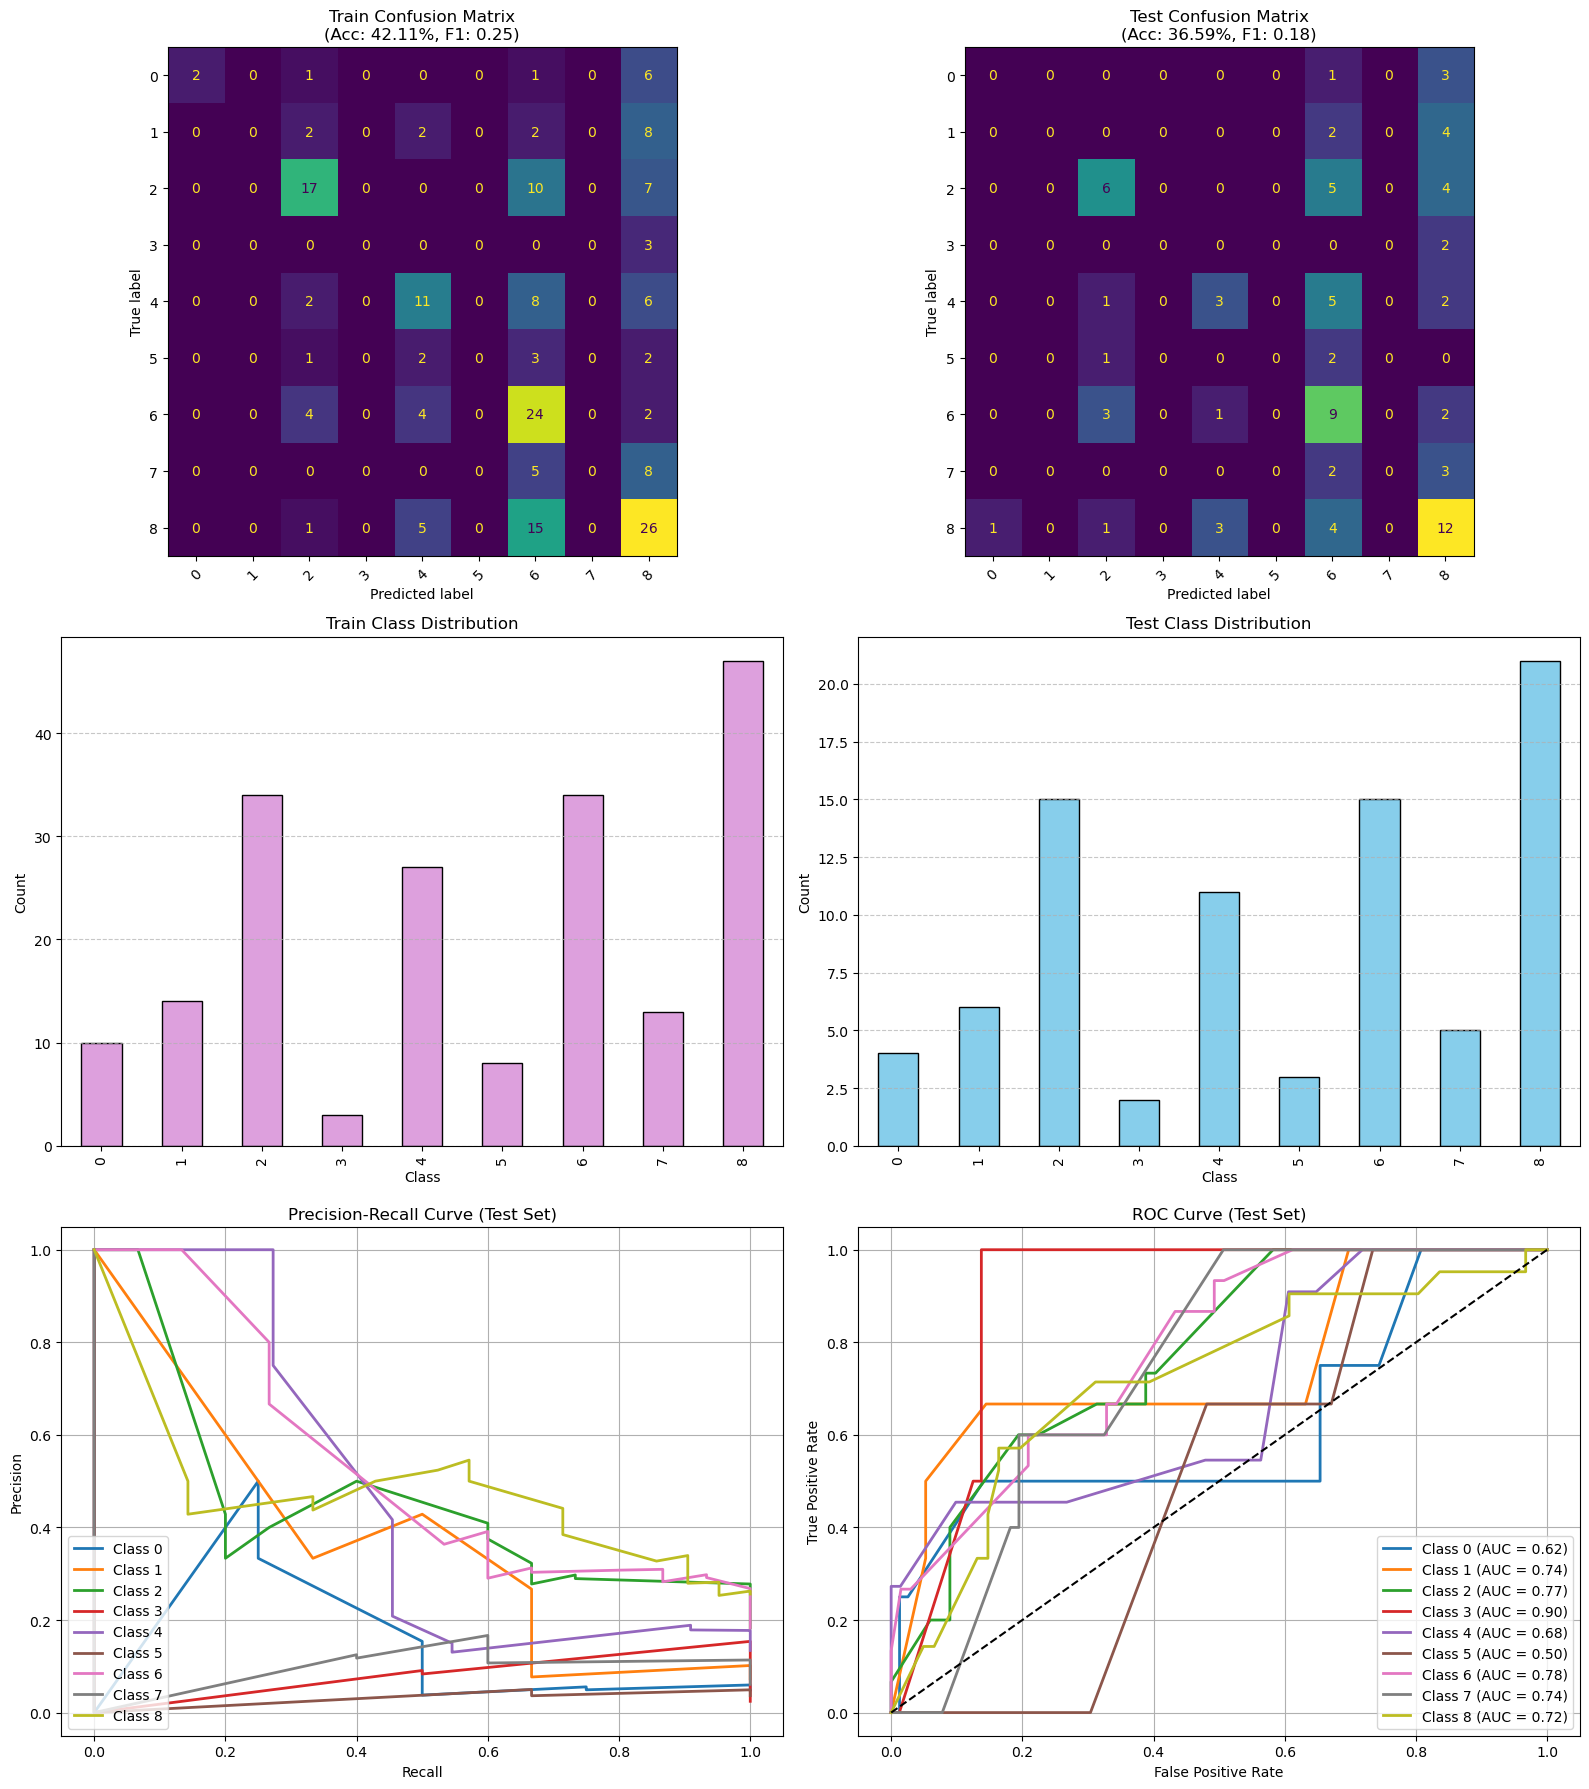

In [7]:
feature_cols = ['NSP', 'Asset Type', 'Reason', 'Status_Code', 
                'Project Work?', 'DNSP Aware?', 'Generator Aware?', 'Inter-Regional']
target_col = 'Duration_Category'

region_models = {}
for region in df['Region'].unique():
    print(f"\n--- Region: {region} ---")
    region_df = df[df['Region'] == region].copy()
    model = train_and_evaluate_tabpfn(region_df, feature_cols, target_col)
    region_models[region] = model